In [1]:
using DFTK
using Printf
using LinearAlgebra
using ForwardDiff
using LinearMaps
using IterativeSolvers
using Plots


a = 10.26  
lattice = a / 2 * [[0 1 1.]; [1 0 1.]; [1 1 0.]]
Si = ElementPsp(:Si; psp=load_psp("hgh/lda/Si-q4"))
atoms = [Si, Si]
positions = [ones(3) / 8, -ones(3) / 8 ]
positions[1] .+= [-0.022, 0.028, 0.035]
model = model_LDA(lattice, atoms, positions)
kgrid=[1, 1, 1]
tol=1e-10
#Calcul de la solution de référence 
basis_ref = PlaneWaveBasis(model; Ecut=500, kgrid=[1, 1, 1])
scfres_ref = self_consistent_field(basis_ref; tol=1e-10);
ψ_ref = DFTK.select_occupied_orbitals(basis_ref, scfres_ref.ψ, scfres_ref.occupation).ψ;
f_ref = compute_forces(scfres_ref);
E_ref=scfres_ref.energies.total;

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.270321383614                   -0.48   16.0    11.9s
  2   -7.285889515690       -1.81       -1.39    1.0    4.43s
  3   -7.286727447909       -3.08       -2.12    3.0    3.94s
  4   -7.286417516068   +   -3.51       -1.87    3.0    3.90s
  5   -7.286755117201       -3.47       -2.53    2.0    3.36s
  6   -7.286770467120       -4.81       -3.16    4.0    4.05s
  7   -7.286771190688       -6.14       -3.90    5.0    4.62s
  8   -7.286771206615       -7.80       -4.27    4.0    4.02s
  9   -7.286771210487       -8.41       -4.95    4.0    4.49s
 10   -7.286771210642       -9.81       -5.52    4.0    5.08s
 11   -7.286771210650      -11.09       -5.81    3.0    3.56s
 12   -7.286771210654      -11.44       -6.46    2.0    3.44s
 13   -7.286771210654      -13.03       -6.94    4.0    4.47s
 14   -7.286771210654      -13.69       -7.46    4.0    5.06s
 15   -7.

In [3]:
#fonction pour appliquer la matrice M
function apply_M(φk, Pk, δφnk, n)
    DFTK.proj_tangent_kpt!(δφnk, φk)
    δφnk = sqrt.(Pk.mean_kin[n] .+ Pk.kin) .* δφnk
    DFTK.proj_tangent_kpt!(δφnk, φk)
    δφnk = sqrt.(Pk.mean_kin[n] .+ Pk.kin) .* δφnk
    DFTK.proj_tangent_kpt!(δφnk, φk)
end
#fonction pour appliquer L'inverse de la matrice M
function apply_inv_M(φk, Pk, δφnk, n)
    DFTK.proj_tangent_kpt!(δφnk, φk)
    op(x) = apply_M(φk, Pk, x, n)
    function f_ldiv!(x, y)
        x .= DFTK.proj_tangent_kpt(y, φk)
        x ./= (Pk.mean_kin[n] .+ Pk.kin)
        DFTK.proj_tangent_kpt!(x, φk)
    end
    J = LinearMap{eltype(φk)}(op, size(δφnk, 1))
    δφnk = cg(J, δφnk; Pl=DFTK.FunctionPreconditioner(f_ldiv!),
              verbose=false, reltol=0, abstol=1e-15)
    DFTK.proj_tangent_kpt!(δφnk, φk)
end


function apply_metric(φ, P, δφ, A::Function)
    map(enumerate(δφ)) do (ik, δφk)
        Aδφk = similar(δφk)
        φk = φ[ik]
        for n = 1:size(δφk,2)
            Aδφk[:,n] = A(φk, P[ik], δφk[:,n], n)
        end
        Aδφk
    end
end
#fonction pour calculer le differentiel en utilisant la fonction ForwardDiff
function df(basis, occupation, ψ, δψ, ρ)
    δρ = DFTK.compute_δρ(basis, ψ, δψ, occupation)
    ForwardDiff.derivative(ε -> compute_forces(basis, ψ.+ε.*δψ, occupation; ρ=ρ+ε.*δρ), 0)
end;
#fonction pour calculer l'erreur en alligniant les deux solutions
function compute_error(basis, ϕ, ψ)
    map(zip(ϕ, ψ)) do (ϕk, ψk)
        S = ψk'ϕk
        U = S*(S'S)^(-1/2)
        ϕk - ψk*U
    end
end




compute_error (generic function with 1 method)

In [5]:
function cal_gamma(basis,scfres,basis_gamma,case)
    #projection de  ψ_ref dans la base gamma
    ψ_ref_réduite = DFTK.transfer_blochwave(ψ_ref,basis_ref,basis_gamma);
    ψ_ref_réduite = DFTK.select_occupied_orbitals(basis_gamma, ψ_ref_réduite, scfres_ref.occupation).ψ;
    ψr = DFTK.transfer_blochwave(scfres.ψ, basis, basis_gamma);
    ρr = compute_density(basis_gamma, ψr, scfres.occupation);
    Er, hamr = energy_hamiltonian(basis_gamma, ψr, scfres.occupation; ρ=ρr);  
    res = DFTK.compute_projected_gradient(basis_gamma, ψr, scfres.occupation);
    res, occ = DFTK.select_occupied_orbitals(basis_gamma, res, scfres.occupation);
    ψr = DFTK.select_occupied_orbitals(basis_gamma, ψr, scfres.occupation).ψ;
    ham_basis=energy_hamiltonian(basis, scfres.ψ, scfres.occupation; ρ=scfres.ρ)[2];
    P = [PreconditionerTPA(basis_gamma, kpt) for kpt in basis_gamma.kpoints]
    map(zip(P, ψr)) do (Pk, ψk)
        DFTK.precondprep!(Pk, ψk)
    end
     # Rayleigh coefficients needed for apply_Ω
    Λ = map(enumerate(ψr)) do (ik, ψk)
        Hk = hamr.blocks[ik]
        Hψk = Hk * ψk
        ψk'Hψk
    end
    if case==1
        Mres = apply_metric(ψr, P, res, apply_inv_M);
        resLF = DFTK.transfer_blochwave(res, basis_gamma, basis);
        resHF = res - DFTK.transfer_blochwave(resLF, basis, basis_gamma);
        e2 = apply_metric(ψr, P, resHF, apply_inv_M);    
        ΩpKe2 = DFTK.apply_Ω(e2, ψr, hamr, Λ) .+ DFTK.apply_K(basis_gamma, e2, ψr, ρr, occ);
        ΩpKe2 = DFTK.transfer_blochwave(ΩpKe2, basis_gamma, basis);
        rhs = resLF - ΩpKe2;
        (; ψ) = DFTK.select_occupied_orbitals(basis, scfres.ψ, scfres.occupation);
        e1 = DFTK.solve_ΩplusK(basis, ψ, rhs, occ; tol).δψ;
        e1 = DFTK.transfer_blochwave(e1, basis, basis_gamma);
        res_schur = e1 + Mres;
        x=res_schur
    end 
    if case==2
        #calcul de l'erreur ψ_ref_réduite-ψr dans la base gamma 
        x = compute_error(basis_gamma, ψr, ψ_ref_réduite);
    end 
    if case==3
        #x égal au vecteur contenant que des 1
        x = [ones(ComplexF64, size(ψr[1])...)]
    end
    
    #projection de x dans la petite base
    xLF=DFTK.transfer_blochwave(x, basis_gamma, basis);
    #remplissage par des 0 dans la base gamma (petite fréquences)
    xLF_projeté=DFTK.transfer_blochwave(xLF, basis, basis_gamma);
    #projection dans la base gamma (grande fréquences)
    xHF=x-DFTK.transfer_blochwave(xLF, basis, basis_gamma);
    #calcul de M22*x
    M2_x = apply_metric(ψr, P, xHF, apply_M)
    #calcul du produit scalaire <M22x,x>
    x_M2_x=real(dot(M2_x,x))

    #calcul de (Ω+K)*x
    J_x=DFTK.apply_Ω(x, ψr, hamr, Λ) .+ DFTK.apply_K(basis_gamma, x, ψr, ρr, occ);
    #calcul de la projection dans la petite base
    J_x_réduite = DFTK.apply_Ω(xLF_projeté, ψr, hamr, Λ) .+ DFTK.apply_K(basis_gamma, xLF_projeté, ψr, ρr, occ);
    #calcul de la prohection dans la base orthogonale (haute fréquences)
    J_x = J_x-J_x_réduite
    #calcul du produit scalaire <(Ω+K)21*x,x>
    x_J_x = real(dot(J_x,x))

    #calcul du paramétre 
    N_gamma=x_M2_x/(x_J_x+x_M2_x)
end

cal_gamma (generic function with 1 method)

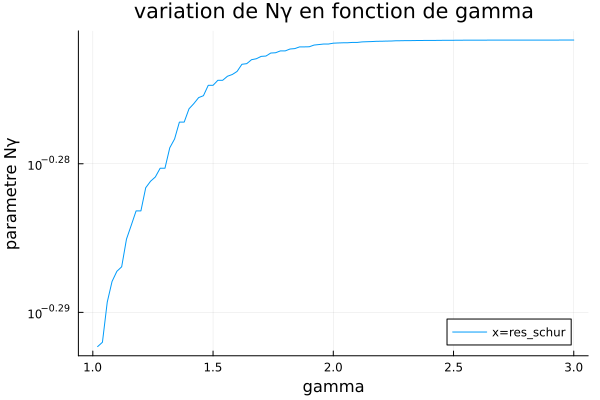

In [15]:
gamm=[]
base_petite = PlaneWaveBasis(model; Ecut=35, kgrid)
scfres = self_consistent_field(base_petite; tol, callback=identity )
for i in 1:101
        base_variable=PlaneWaveBasis(model; Ecut=(1+(2/100)*(i-1))*35, kgrid)
        gamma=cal_gamma(base_petite,scfres,base_variable,1)
        push!(gamm,norm(gamma))
end 

using Plots
pl=plot(1:2/100:3,gamm,xlabel="gamma",ylabel="parametre Nγ",yscale=:log10,title="variation de Nγ en fonction de gamma",label="x=res_schur")

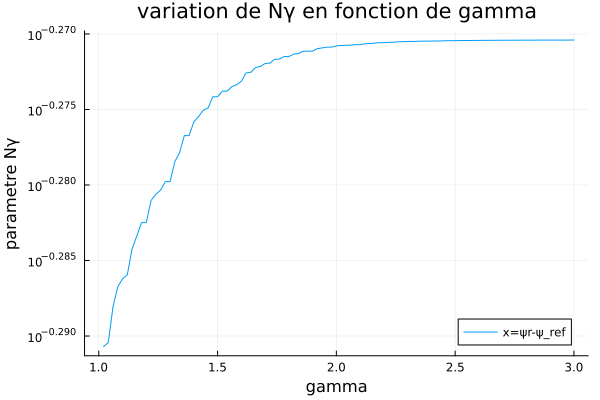

In [13]:
gamm=[]
base_petite = PlaneWaveBasis(model; Ecut=35, kgrid)
scfres = self_consistent_field(base_petite; tol, callback=identity )
for i in 1:101
        base_variable=PlaneWaveBasis(model; Ecut=(1+(2/100)*(i-1))*35, kgrid)
        gamma=cal_gamma(base_petite,scfres,base_variable,2)
        push!(gamm,norm(gamma))
end 

using Plots
pl=plot(1:2/100:3,gamm,xlabel="gamma",ylabel="parametre Nγ",yscale=:log10,title="variation de Nγ en fonction de gamma",label="x=ψr-ψ_ref")

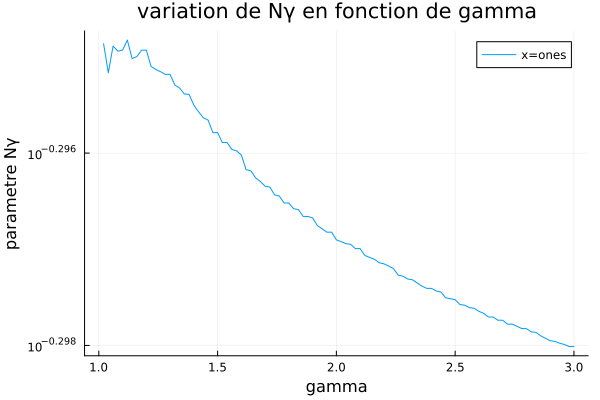

In [17]:
gamm=[]
base_petite = PlaneWaveBasis(model; Ecut=35, kgrid)
scfres = self_consistent_field(base_petite; tol, callback=identity )
for i in 1:101
        base_variable=PlaneWaveBasis(model; Ecut=(1+(2/100)*(i-1))*35, kgrid)
        gamma=cal_gamma(base_petite,scfres,base_variable,3)
        push!(gamm,norm(gamma))
end 

using Plots
pl=plot(1:2/100:3,gamm,xlabel="gamma",ylabel="parametre Nγ",yscale=:log10,title="variation de Nγ en fonction de gamma",label="x=ones")